# Train Model

## Load and Clean Data

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

CSV_PATH = "data/per_frame_data.csv"
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["continuous_mos", "vmaf", "psnr", "ssim", "bitrate"])

## Define Features and Target

In [19]:
feature_cols = [
    "vmaf",
    "psnr",
    "ssim",
    "strred",
    "bitrate",
    "is_rebuffered",
    "spatial_info",
    "temporal_info",
]

X = df[feature_cols]
y = df["continuous_mos"]

groups = df["video_name"]

## Train/test split

In [20]:
unique_videos = df["video_name"].unique()
train_videos, test_videos = train_test_split(
    unique_videos, test_size=0.2, random_state=42
)

train_mask = df["video_name"].isin(train_videos)
test_mask = df["video_name"].isin(test_videos)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train frames: {len(X_train)}, Test frames: {len(X_test)}")
print(f"Train videos: {len(train_videos)}, Test videos: {len(test_videos)}")

Train frames: 249173, Test frames: 62915
Train videos: 336, Test videos: 84


## Define and Train Model

In [21]:
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Evaluate

In [22]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

print("\n=== Test Performance (per-frame) ===")
print(f"RMSE:          {rmse:.4f}")
print(f"MSE:           {mse:.4f}")
print(f"R^2:           {r2:.4f}")
print(f"Pearson r:     {pearson_corr:.4f}")
print(f"Spearman rho:  {spearman_corr:.4f}")


=== Test Performance (per-frame) ===
RMSE:          0.4095
MSE:           0.1677
R^2:           0.7345
Pearson r:     0.8574
Spearman rho:  0.8538


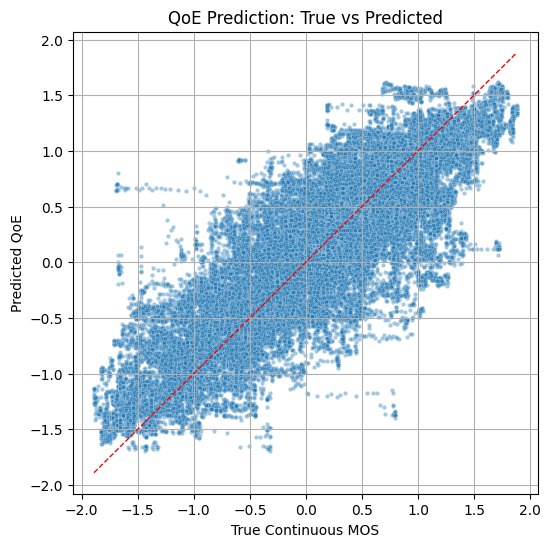

In [23]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, s=10)
plt.xlabel("True Continuous MOS")
plt.ylabel("Predicted QoE")
plt.title("QoE Prediction: True vs Predicted")
plt.grid(True)

# Diagonal line for perfect prediction
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.show()

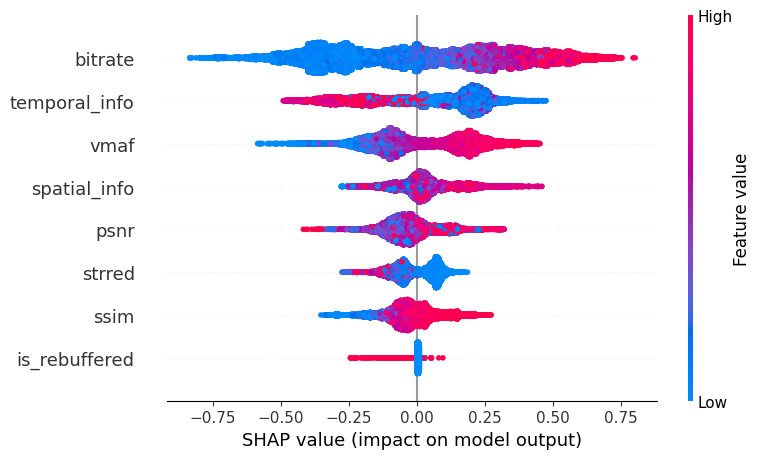

In [24]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

In [25]:
import joblib

joblib.dump(model, "models/qoe_model_xgb_v2.0.pkl")
print("\nSaved model to models/qoe_model_xgb_v2.0.pkl")

pred_df = df[test_mask].copy()
pred_df["qoe_pred"] = y_pred
pred_df.to_csv("data/per_frame_predictions_test.csv", index=False)
print("Saved per-frame predictions to data/per_frame_predictions_test.csv")


Saved model to models/qoe_model_xgb_v2.0.pkl
Saved per-frame predictions to data/per_frame_predictions_test.csv
